### Program written by Pablo Sánchez-Palencia, 2022
Built-up on the basis of the code previously written by Scott Midgley

Scope: To train and test GBDT model for band gap and mixing energy screening in the configurational space of Sn2GeN4 spinel solid solutions.  

In [1]:
### USER INPUT REQUIRED ###

# Define percentage of training data to use for training. 
split = 20
#split = 50
#split = 80

# Define the structural descriptor to use for training the model
#descriptor="Coulomb_mm"
#descriptor="Coulomb_ds"
#descriptor="Coulomb_corr"
#descriptor="Sine_mm"
#descriptor="Sine_ds"
#descriptor="Ewald_mm"
#descriptor="Ewald_ds"
#descriptor="MBTR"
descriptor="CorrM"

#Define property to predict with the model
#feature="SCF"
feature="MixE";labelsname="Mixing Energy"
#feature="BGE";labelsname="Bandgap"
#feature="HSE-corr";labelsname="Bandgap"

In [2]:
# Import modules.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,r2_score
import sklearn
import time
import pickle
import shap

In [3]:
# Define GBDT hyperparameters. 
params = {'n_estimators': 1000,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
model = GradientBoostingRegressor(**params)

In [4]:
#Define generic functions to run ensembles
def train_predict_model(model):
    start=time.time()
    model.fit(Xtrain, ytrain)
    end=time.time()
    print(f"Runtime of the program is {(end - start)/60} min")
    predictions = model.predict(Xtest)
    return predictions 

def score_model(realval,preds,print_results=False,graph=False,print_ingraph=False,savegraph=False):
    mae = mean_absolute_error(realval,preds)*1000
    maxerr= max(abs(preds.reshape(len(preds),)-realval))*1000
    r2=r2_score(realval,preds)
    if print_results==True:
        print('Mean absolute error {} meV'.format(mae))
        print('Maximum error {} meV'.format(maxerr))
        print('R2 = {}'.format(r2))
    if graph==True:
        if savegraph==True:
            plt.figure(dpi=600)
        else:
            plt.figure()
        plt.plot(realval.reshape(len(preds),),preds,'o')
        vmin=min(min(realval),min(preds));vmax=max(max(realval),max(preds))
        eje=np.linspace(vmin,vmax,10)
        plt.plot(eje,eje)
        plt.ylabel("Predicted values")
        plt.xlabel("Calculated values")
        plt.title("Bandgaps (eV)")
        ax=plt.gca()
        ax.set_xlim([vmin-0.01,vmax+0.01]);ax.set_ylim([vmin-0.01,vmax+0.01])
        ax.set_aspect('equal', adjustable='box')
        if print_ingraph==True:
            xtags=vmin+0.07*(vmax-vmin)
            yperc=np.array([0.9,0.85,0.8,0.75,0.7,0.65,0.6])
            ytags=vmin+yperc*(vmax-vmin)
            plt.text(xtags,ytags[0], "MAE = "+'%.2f' % (mae) +" meV")
            plt.text(xtags,ytags[1], r'$\epsilon$$_{max}$ = '+'%.2f' % (maxerr) +" meV")
            plt.text(xtags,ytags[2], r'R$^2$ = '+'%.3f' % r2)
        if savegraph==True:
            plt.savefig('GBDT_'+descriptor+feature+".png")
        plt.show()
        plt.close()
    return mae,maxerr,r2

## Load the data

In [5]:
# Import data and shuffle (optional).
ener      = pd.read_pickle('../descriptors/input_data_cm.pkl')
sm_data   = pd.read_pickle('../descriptors/input_data_sm.pkl')
em_data   = pd.read_pickle('../descriptors/input_data_em.pkl')
mbtr_data = pd.read_pickle('../descriptors/input_data_mbtr.pkl')

ener["Sine_ds"]=sm_data["Sine_ds"]
ener["Sine_mm"]=sm_data["Sine_mm"]
ener["Ewald_ds"]=em_data["Ewald_ds"]
ener["Ewald_mm"]=em_data["Ewald_mm"]
ener["MBTR"]=mbtr_data["MBTR"]

ener = ener.sample(frac=1,random_state=91)

In [6]:
# Split data frame into training, validation, and testing data. 
l=len(ener)

e_test = ener.iloc[:l//10+1] #10% of data for testing model
e_val = ener.iloc[l//10+1:l//10*2+1] #10% of data for validation

if split == int(20):
    e_train = ener.iloc[l//10*2+1:l//10*4+1] #30% of data for training
elif split == int(50):
    e_train = ener.iloc[l//10*2+1:l//10*7+1] #50% of data for training
elif split == int(80):
    e_train = ener.iloc[l//10*2+1:l] #80% of data for training
else:
    print('Error: please choose a valid train/test split.')

In [7]:
# Print number of training data points
print('Number of training data points = ', len(e_train))
# Convert Pandas columns to Numpy arrays. Reshaping to obtain array of nested brackets. 
Xtrain = e_train[descriptor].to_numpy()
Xtrain = np.stack(Xtrain)
Xval   = e_val[descriptor].to_numpy()
Xval   = np.stack(Xval)
Xtest  = e_test[descriptor].to_numpy()
Xtest  = np.stack(Xtest)
ytrain = e_train[feature].to_numpy()
yval   = e_val[feature].to_numpy()
ytest  = e_test[feature].to_numpy()
itrain = e_train['tag'].to_numpy()
ival   = e_val['tag'].to_numpy()
itest  = e_test['tag'].to_numpy()

Number of training data points =  202


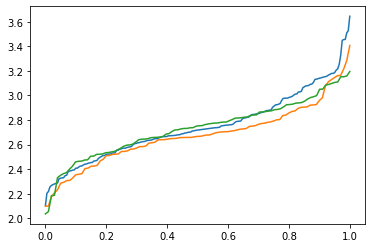

In [8]:
#Visualization of the distribution of values among the different sets: training, validation and test.
plt.figure()
plt.plot(np.linspace(0,1,len(ytrain)),sorted(ytrain))
plt.plot(np.linspace(0,1,len(yval)),sorted(yval))
plt.plot(np.linspace(0,1,len(ytest)),sorted(ytest))
plt.show()
plt.close()

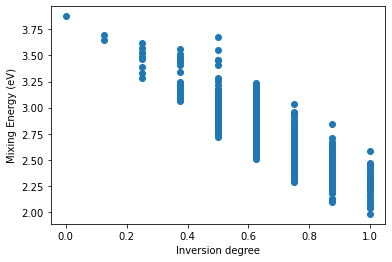

In [9]:
#Visualization of the distribution of DFT calculated values across inversion degrees
plt.figure()
plt.plot(ener['inv'],ener[feature],'o')
plt.xlabel("Inversion degree")
plt.ylabel(labelsname+" (eV)")
plt.show()
plt.close()

## Train a model from scrach 

You can retrain a new model on any amount of the data that you would like to use.
Note - the model will probably take around 8000 epochs to reach the stopping creteria prescribed below (these are the criteria used in the paper).

You can build either the shallow or the deep network using the `shallow_mlp` and `deep_mlp` functions respectively.

The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.


Runtime of the program is 0.008364319801330566 min
Mean absolute error 28.015673180206278 meV
Maximum error 145.53584633787065 meV
R2 = 0.9728561524582201


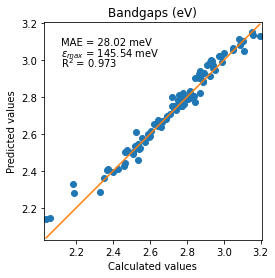

In [10]:
# Train GBDT 
ypred = train_predict_model(model)
mae,maxerr,r2=score_model(ytest,ypred,print_results=True,graph=True,print_ingraph=True)

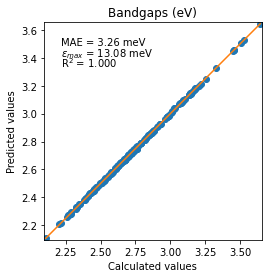

In [11]:
trainpred=model.predict(Xtrain)
mae,maxerr,r2=score_model(ytrain,trainpred,graph=True,print_ingraph=True)

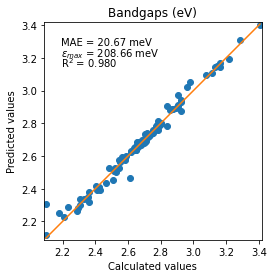

In [12]:
valpred=model.predict(Xval)
mae,maxerr,r2=score_model(yval,valpred,graph=True,print_ingraph=True)

## Running the model recursively in ensembles 

You can train the model in ensembles of variable size and get averages of metrics and predictions.

In [13]:
n=10
preds_ens = np.zeros(shape=(n, len(Xtest)))
for i in range(n):
    model = GradientBoostingRegressor(**params)
    sklearn.utils.shuffle(Xtrain, ytrain)
    preds_ens[i,:] = train_predict_model(model)
mean_preds = np.mean(preds_ens, axis=0)
mean_std = np.std(preds_ens, axis=0)

The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.


Runtime of the program is 0.008430242538452148 min


The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.


Runtime of the program is 0.008477962017059327 min


The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.


Runtime of the program is 0.00856549342473348 min


The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.


Runtime of the program is 0.008016856511433919 min


The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.


Runtime of the program is 0.008267760276794434 min


The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.


Runtime of the program is 0.008193182945251464 min


The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.


Runtime of the program is 0.008046348889668783 min


The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.


Runtime of the program is 0.008342965443929037 min


The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.


Runtime of the program is 0.008224987983703613 min


The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.


Runtime of the program is 0.008117306232452392 min


Mean absolute error 27.92445033001247 meV
Maximum error 142.81407998408912 meV
R2 = 0.9730926436625351


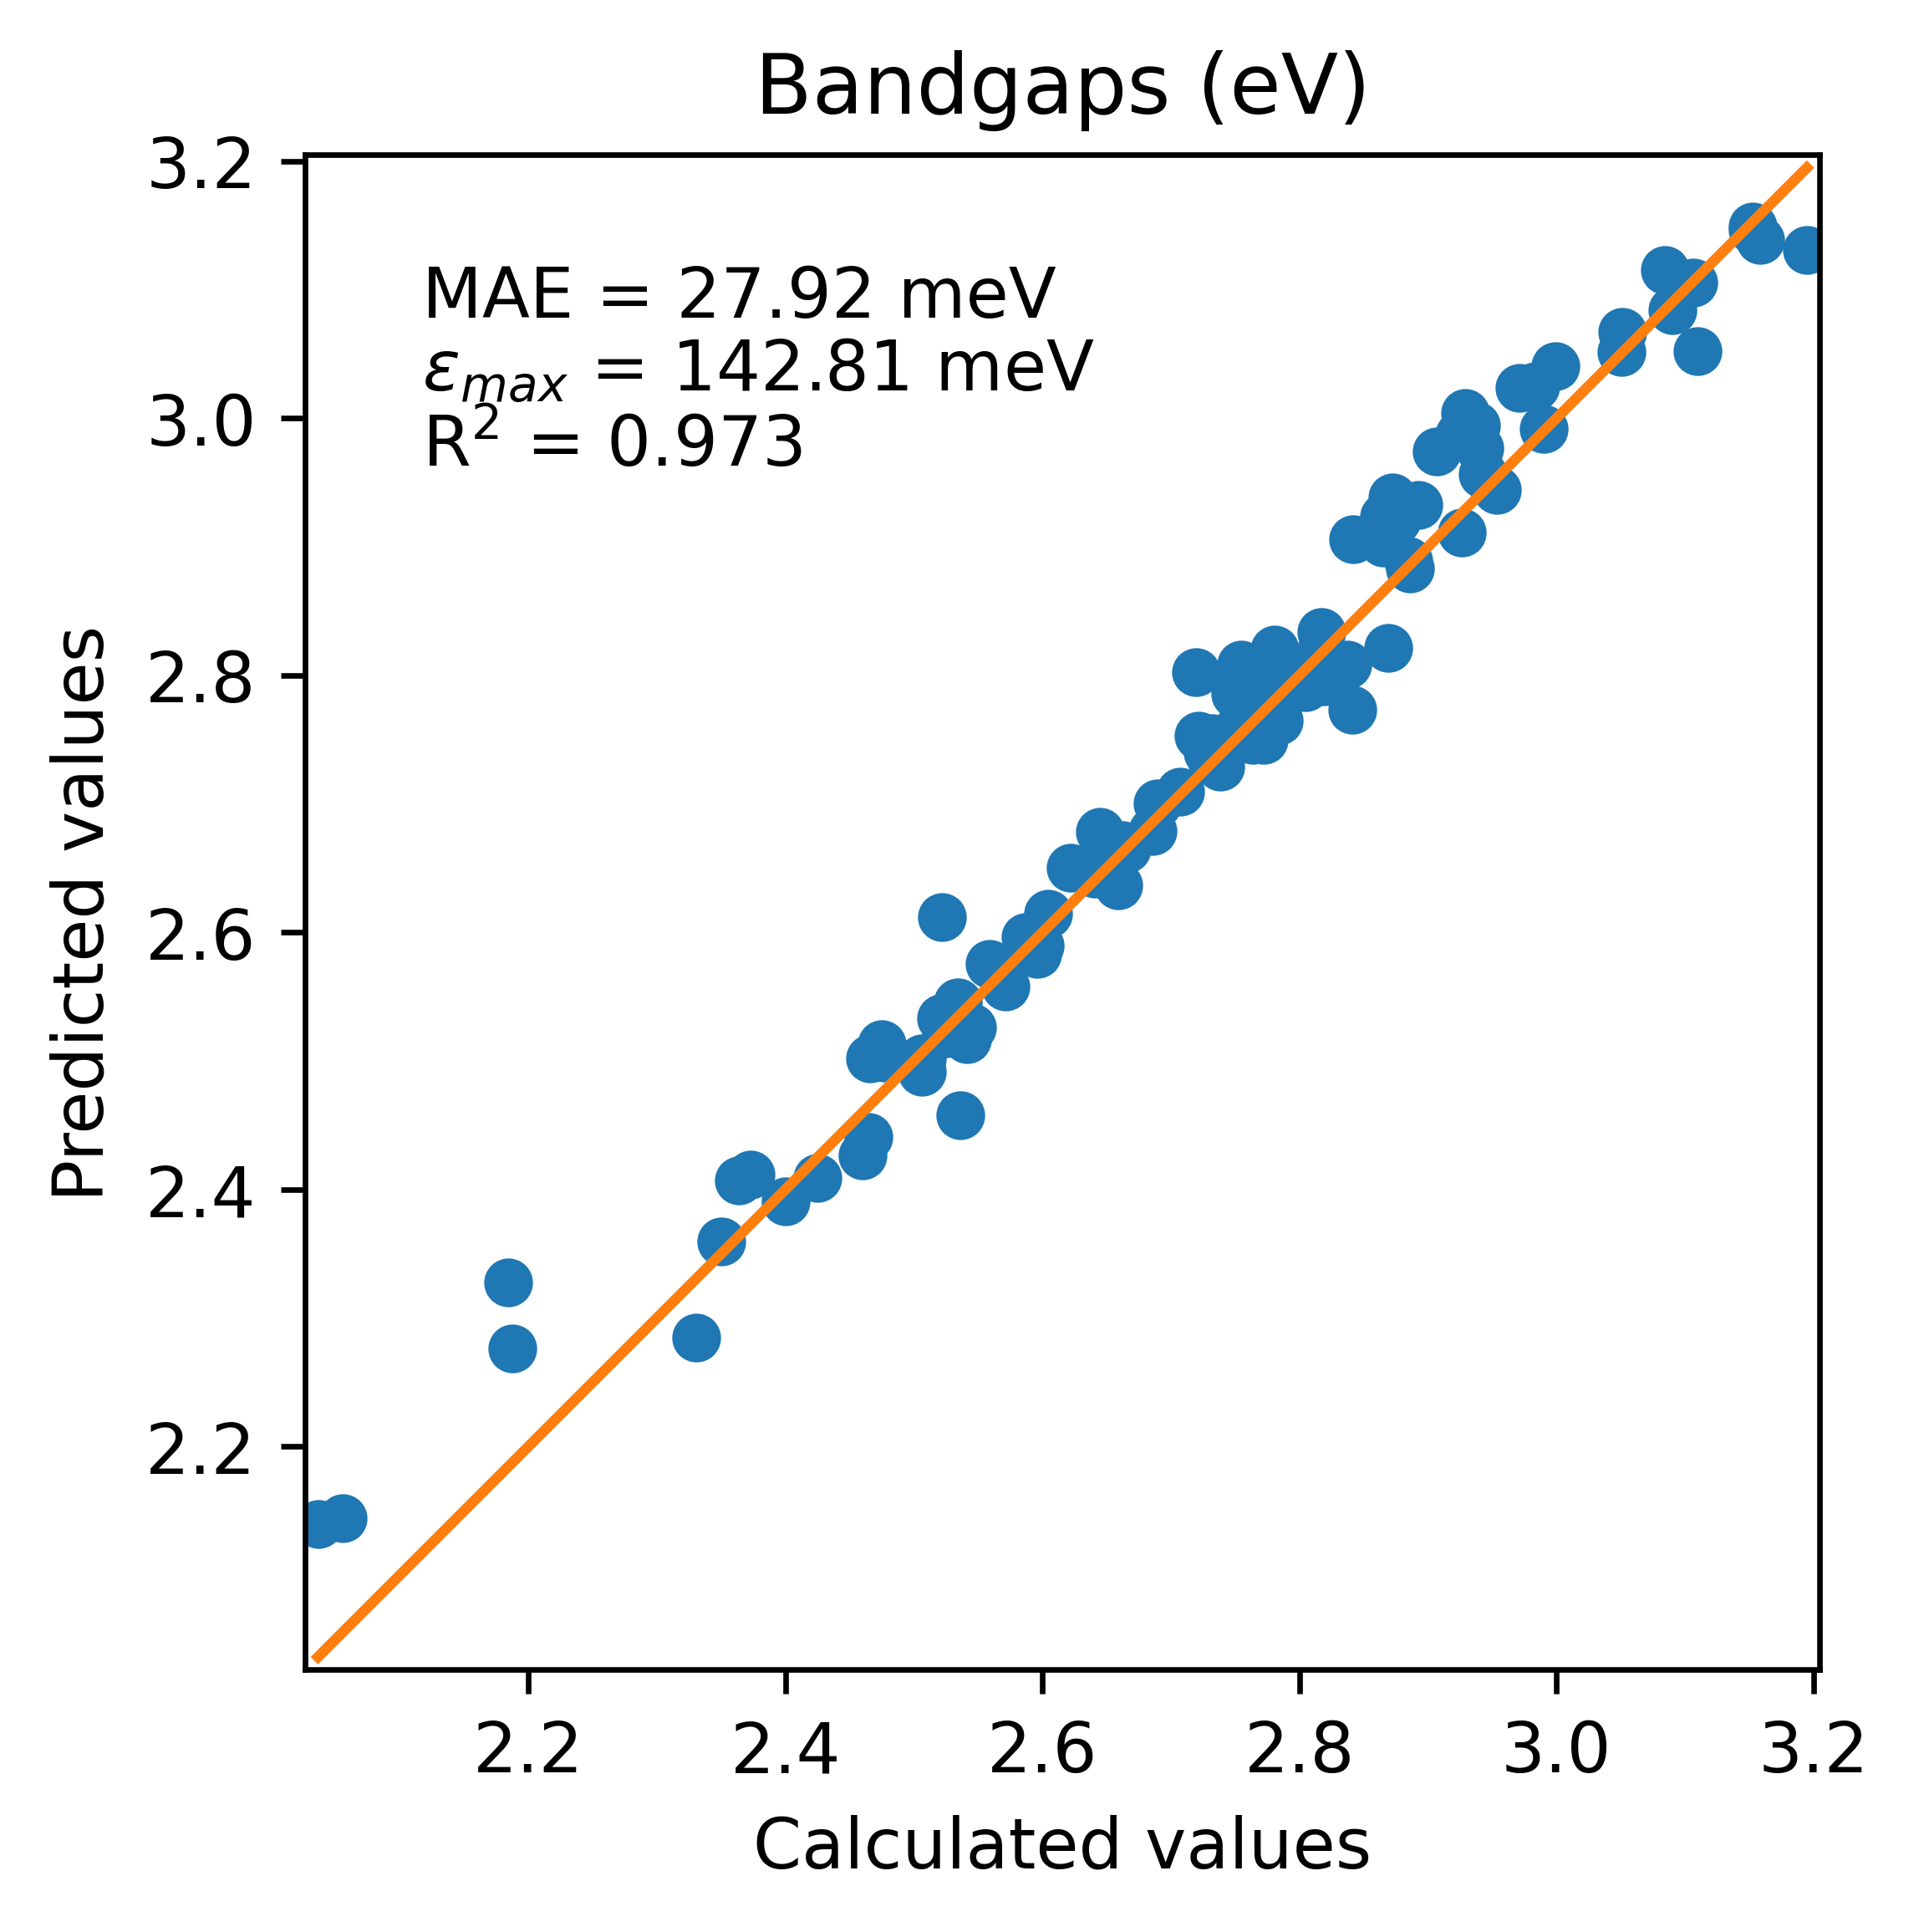

In [14]:
mae_means,maxerr_means,r2_means=score_model(ytest,mean_preds,print_results=True,graph=True,print_ingraph=True,savegraph=True)

In [15]:
all_mae=[];all_maxerr=[];all_r2=[];
for i in range(n):
    mae,maxerr,r2=score_model(ytest,preds_ens[i,:])
    all_mae.append(mae)
    all_maxerr.append(maxerr)
    all_r2.append(r2)
print(np.mean(all_mae))
print(np.mean(all_maxerr))
print(np.mean(all_r2))

27.947936071785364
142.81407998408858
0.9730725681116492


## SHAP analysis 

You can retrain a new model on any amount of the data that you would like to use.
Note - the model will probably take around 8000 epochs to reach the stopping creteria prescribed below (these are the criteria used in the paper).

You can build either the shallow or the deep network using the `shallow_mlp` and `deep_mlp` functions respectively.

In [16]:
explainer = shap.Explainer(model, Xtrain)
shap_values = explainer(Xtest)

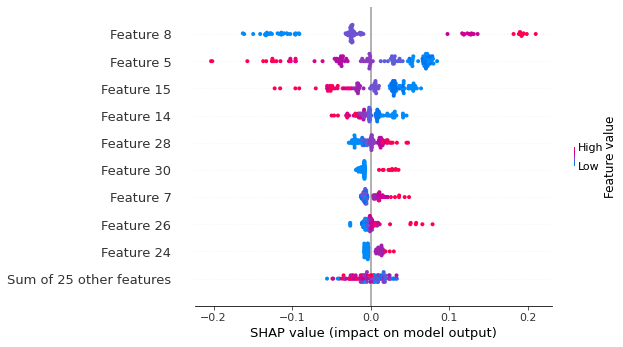

In [17]:
shap.plots.beeswarm(shap_values)